# Домашнее задание по теме "Проблема качества данных"

***Описание задания:***  
По образу практики попробуйте создать искусственный датасет с лишними столбцами. Целевую метку, при правильной обработке данных, формируйте таким образом, чтобы без затруднений её смогла описать линейная модель. Ориентируйтесь на то, что было показано во время занятия, и каждый шаг описывайте в markdown. Здесь важно видеть ваш ход мысли. Не бойтесь ошибиться или написать не то. Данное задание не имеет какого-то “правильного” решения. Цель - достичь базового понимания проблемы. Чем больше вы фантазируете, тем лучше. Тем не менее, старайтесь представить те ситуации, которые по-вашему мнению могли бы быть в реальных данных.

***План работы:***
1. Создать датасет
2. Сделать предобработку данных таким образом, чтобы линейная модель могла описать данные
3. Обучить линейную регрессию
4. Создать полиномиальные фичи
6. Написать выводы по работе

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### Шаг 1. Создание датасета

Можно придумать датасет, где целевой признак будет количество людей, живущих в многоквартирном доме, а фичи -  этажность дома, количество подъездов, среднее количество людей, проживающих в одной квартире и количество квартир в доме:

In [2]:
# Создаём сэмпл
n_samples = 1000

total_floors = np.random.choice(50, n_samples) + 1
number_of_entrances = np.random.choice(5, n_samples) + 1
mean_per_family = np.random.choice(5, n_samples) + 1
total_apartments = (np.random.choice(5, n_samples) + 1) * total_floors

all_people = (mean_per_family * total_apartments * 1.2).round(0)

data = pd.DataFrame({'total_floors': total_floors, 'total_apartments': total_apartments,  'number_of_entrances': number_of_entrances, 'mean_per_family': mean_per_family, 'all_people': all_people})

### Шаг 2. Предобработка и EDA

Теперь представим, что такой датасет нам отправили и сказали его предобработать. Выведем на экран первые 5 строчек, чтобы познакомиться с ним:

In [3]:
data.head(5)

,total_floors,total_apartments,number_of_entrances,mean_per_family,all_people
0,15,30,5,2,72.0
1,47,94,4,3,338.0
2,4,4,2,1,5.0
3,24,48,3,3,173.0
4,19,38,2,2,91.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_floors         1000 non-null   int32  
 1   total_apartments     1000 non-null   int32  
 2   number_of_entrances  1000 non-null   int32  
 3   mean_per_family      1000 non-null   int32  
 4   all_people           1000 non-null   float64
dtypes: float64(1), int32(4)
memory usage: 23.6 KB


Итак, что мы имеем: пропусков в датасете у нас нет. Тип данных не соответствует только в целевом признаке. Поскольку 1,5 землекопа быть не может, присвоим столбцу тип данных int:

In [5]:
data['all_people'] = data['all_people'].astype('int')
type(data['all_people'][0])

numpy.int32

Посмотрим, есть ли зависимости в наших данных:

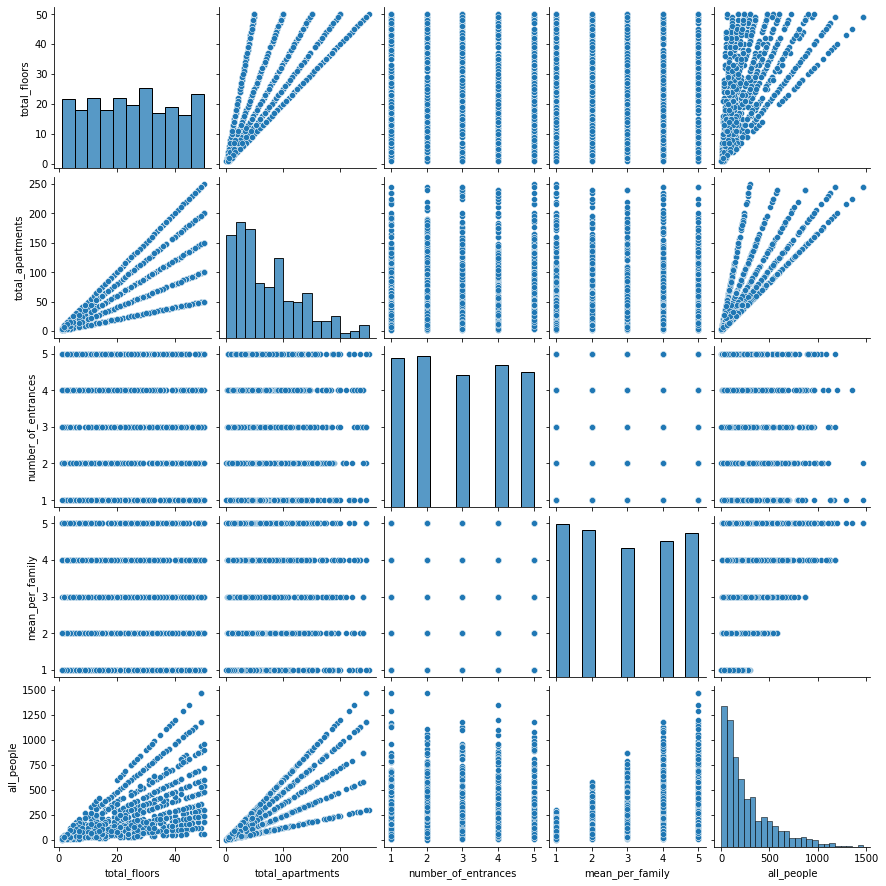

In [6]:
sns.pairplot(data)

- Как видно на графиках отношения между всеми парами переменных некая зависимость присутствует между количеством этажей и целевой переменной, а также между общим количеством квартир в доме и целевой переменной. Чем больше этажей и квартир, тем больше людей живет в доме. При этом стоит отметить, что на этих зависимостях не один луч, а 5 и более. Значит, зависимость нельзя назвать чисто линейной.  
- Также отметим некую зависимость между средним числом людей в семье и целевой переменной. Она нелинейна и неочевидна, но, тем не менее, есть. Мы видим, что там, где в среднем 1 человек в семье, показатель "общее количество людей в квартире" находится в пределах от 0 до 400, а при среднем количестве людей в квартире, равном 5, - уже интервал значений от 0 до 1500.  
- Еще обратим внимание на зависимость между столбцами "всего этажей" и "всего квартир". Действительно, чем больше этажей, тем больше и квартир (вполне логично). Запомним эту информацию, т.к., возможно, один из признаков придется убрать для более эффективного обучения.

Если бы данные были не рандомные, то зависимостей было бы больше. Можно было бы поискать выбросы, поработать над ними. Сейчас же данные все в разброс. Особенно столбец с числом подъездов - он ни с чем не коррелируется.

Поэтому переходим к обучению модели:

### Шаг 3. Обучение модели линейной регрессии

In [7]:
X = data.drop('all_people', axis=1)
y = data['all_people']

In [8]:
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(X)
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [-0.1068976   3.48517343 -1.24472894 90.31201384]
Bias: -255.79442352860377
Error: 71.93818488411259


MAE достаточно большая. Попроуем уменьшить ее. Уберем коррелирующий признак: например, количество этажей:

In [9]:
X1 = data.drop(['all_people', 'total_floors'], axis=1)
y = data['all_people']

reg1 = LinearRegression().fit(X1, y)
print('Weights: {}'.format(reg1.coef_))
print('Bias: {}'.format(reg1.intercept_))

pred_values1 = reg1.predict(X1)
print('Error: {}'.format(mean_absolute_error(pred_values1, y)))

Weights: [ 3.46654616 -1.24607869 90.34002921]
Bias: -257.1868166942035
Error: 71.95498752640877


Ошибка даже увеличилась. Что можем еще сделать? Добавим новый признак: количество квартир на этаже:

In [10]:
data['apart_per_floor'] = data['total_apartments'] / data['total_floors']
data['apart_per_floor'] = data['apart_per_floor'].astype('int')
data.head()

,total_floors,total_apartments,number_of_entrances,mean_per_family,all_people,apart_per_floor
0,15,30,5,2,72,2
1,47,94,4,3,338,2
2,4,4,2,1,5,1
3,24,48,3,3,173,2
4,19,38,2,2,91,2


И снова обучим модель:

In [11]:
X2 = data.drop('all_people', axis=1)
y = data['all_people']

reg2 = LinearRegression().fit(X2, y)
print('Weights: {}'.format(reg2.coef_))
print('Bias: {}'.format(reg2.intercept_))

pred_values2 = reg2.predict(X2)
print('Error: {}'.format(mean_absolute_error(pred_values2, y)))

Weights: [ 0.25785679  3.36226926 -1.35224986 90.2316969   4.07664428]
Bias: -267.40402897397706
Error: 72.01665471565406


Добавим теперь столбец с количеством квартир в подъезде:

In [12]:
data['apart_per_entrances'] = data['total_apartments'] / data['number_of_entrances']
data['apart_per_entrances'] = data['apart_per_entrances'].astype('int')
data.head()

,total_floors,total_apartments,number_of_entrances,mean_per_family,all_people,apart_per_floor,apart_per_entrances
0,15,30,5,2,72,2,6
1,47,94,4,3,338,2,23
2,4,4,2,1,5,1,2
3,24,48,3,3,173,2,16
4,19,38,2,2,91,2,19


In [13]:
X3 = data.drop('all_people', axis=1)
y = data['all_people']

reg3 = LinearRegression().fit(X3, y)
print('Weights: {}'.format(reg3.coef_))
print('Bias: {}'.format(reg3.intercept_))

pred_values3 = reg3.predict(X3)
print('Error: {}'.format(mean_absolute_error(pred_values3, y)))

Weights: [ 2.55990006e-01  3.35555001e+00 -1.12692494e+00  9.02318832e+01
  4.05201638e+00  1.57585415e-02]
Bias: -267.9913493425316
Error: 72.01225339638852


А если без apart_per_floor?

In [14]:
X4 = data.drop(['all_people', 'apart_per_floor'], axis=1)
y = data['all_people']

reg4 = LinearRegression().fit(X4, y)
print('Weights: {}'.format(reg4.coef_))
print('Bias: {}'.format(reg4.intercept_))

pred_values4 = reg4.predict(X4)
print('Error: {}'.format(mean_absolute_error(pred_values4, y)))

Weights: [-1.06401384e-01  3.47417896e+00 -9.13682238e-01  9.03115735e+01
  2.32193377e-02]
Bias: -256.76314929542633
Error: 71.93357801112259


Итак, в сравнении с первой моделью ошибка стала меньше, но смещение больше. Причем чем больше признаков, тем больше смещение.  
Модель может предсказывать, но не так эффективно, как хотелось бы.  
По аналогии с данными из ноутбука преподавателя создадим новый признак, в котором подскажем модели, как же в итоге создавался наш таргет. Не будем брать 2% отклонения, что мы заложили изначально, но столбцы перемножим:

In [15]:
data['mult'] = data['mean_per_family'] * data['total_apartments']
data.head()

,total_floors,total_apartments,number_of_entrances,mean_per_family,all_people,apart_per_floor,apart_per_entrances,mult
0,15,30,5,2,72,2,6,60
1,47,94,4,3,338,2,23,282
2,4,4,2,1,5,1,2,4
3,24,48,3,3,173,2,16,144
4,19,38,2,2,91,2,19,76


Обучим модель, используя только этот признак, а затем используем все признаки вкупе. Посмотрим, что получится:

In [16]:
X5 = data[['mult']]
y = data['all_people']

reg5 = LinearRegression().fit(X5, y)
print('Weights: {}'.format(reg5.coef_))
print('Bias: {}'.format(reg5.intercept_))

pred_values5 = reg5.predict(X5)
print('Error: {}'.format(mean_absolute_error(pred_values5, y)))

Weights: [1.19998418]
Bias: 0.005323694033791071
Error: 0.15902268315663431


Вот и результат. Ошибка минимальна. Смещение также близится к нулю.

Обучим теперь на всех признаках вместе:

In [17]:
X6 = data.drop('all_people', axis=1)
y = data['all_people']

reg6 = LinearRegression().fit(X6, y)
print('Weights: {}'.format(reg6.coef_))
print('Bias: {}'.format(reg6.intercept_))

pred_values6 = reg6.predict(X6)
print('Error: {}'.format(mean_absolute_error(pred_values6, y)))

Weights: [-2.13600408e-05 -1.97292602e-04 -9.58456574e-03 -4.29521434e-03
  2.55536471e-03 -1.68988905e-04  1.20004901e+00]
Bias: 0.04550263385993958
Error: 0.16199830884693342


Здесь смещение получилось побольше, но при этом ошибка не сильно изменилась.  
Пришло время посмотреть, какие признаки оказались наиболее значимыми для обучения:

Text(0.5, 1.0, 'Feature importance using Linear Regression Model')

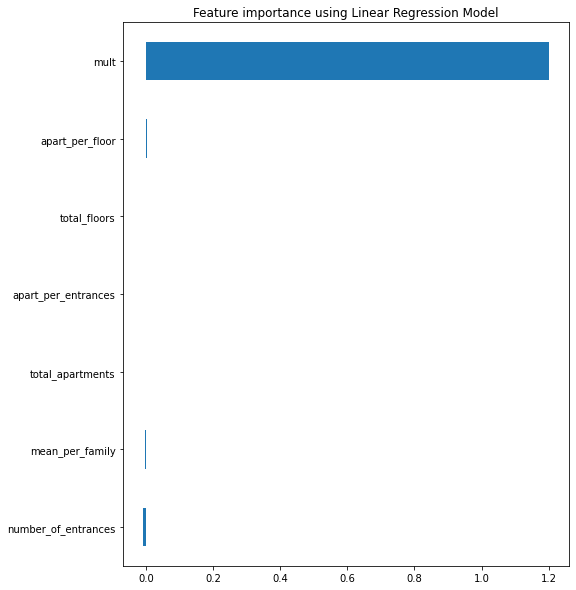

In [18]:
coef = pd.Series(reg6.coef_, index = X6.columns)
imp_coef = coef.sort_values()

plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression Model")

Что и требовалось доказать. Признак mult оказался наиболее значимым. На втором месте - количество подъездов, далее - количество квартир на этаже и среднее число людей в семье.  
Что удивило: признак с количеством подъездов никак не участвовал в создании целевого признака, но он всё же оказался важен.  
Тогда исключим остальные признаки из обучения и посмотрим, что получится:

In [23]:
X7 = data[['number_of_entrances', 'mean_per_family', 'apart_per_floor', 'mult']]
y = data['all_people']
reg7 = LinearRegression().fit(X7, y)
print('Weights: {}'.format(reg7.coef_))
print('Bias: {}'.format(reg7.intercept_))
pred_values7 = reg7.predict(X7)
print('Error: {}'.format(mean_absolute_error(pred_values7, y)))

Weights: [-7.22808601e-03  1.09994215e-03  7.57861598e-04  1.19997836e+00]
Bias: 0.022408571692778878
Error: 0.16169936849703612


Ошибка и смещение стали еще меньше. Это значит, что мы сделали правильный выбор, убрав часть неважных для обучения признаков.

Пойдем дальше и посмотрим, как справится с задачей полиномиальная регрессия.

### Шаг 4. Создание полиномиальных признаков

Для начала вернем датасет в изначальное состояние:

In [24]:
d = data[['total_floors', 'total_apartments', 'number_of_entrances', 'mean_per_family', 'all_people']]
d.head()

,total_floors,total_apartments,number_of_entrances,mean_per_family,all_people
0,15,30,5,2,72
1,47,94,4,3,338
2,4,4,2,1,5
3,24,48,3,3,173
4,19,38,2,2,91


In [25]:
poly = PolynomialFeatures(2)   # пока сделаем вторую степень, чтобы излишне не усложнять

In [27]:
X_p = poly.fit_transform(d.drop('all_people', axis=1))
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [28]:
y = d['all_people']

In [29]:
reg8 = LinearRegression().fit(X_p, y)
print('Weights: {}'.format(reg8.coef_))
print('Bias: {}'.format(reg8.intercept_))

pred_values8 = reg8.predict(X_p)
print('Error: {}'.format(mean_absolute_error(pred_values8, y)))

Weights: [ 0.00000000e+00 -6.89147277e-04 -6.39552127e-04 -5.29401309e-02
 -2.67951979e-02  1.22849082e-05 -8.09196372e-06 -1.70563463e-04
  3.28223096e-04  2.49727445e-06  1.05955565e-04  1.20000449e+00
  5.39801035e-03  3.42041964e-03  1.23664689e-03]
Bias: 0.15261603553875602
Error: 0.16194625804145987


Что можно сказать: смещение стало прилично так больше, MAE изменилась не сильно, но всё же в бОльшую сторону.  
    Какие признаки в фаворе у модели?

Text(0.5, 1.0, 'Poly Feature importance using Linear Regression Model')

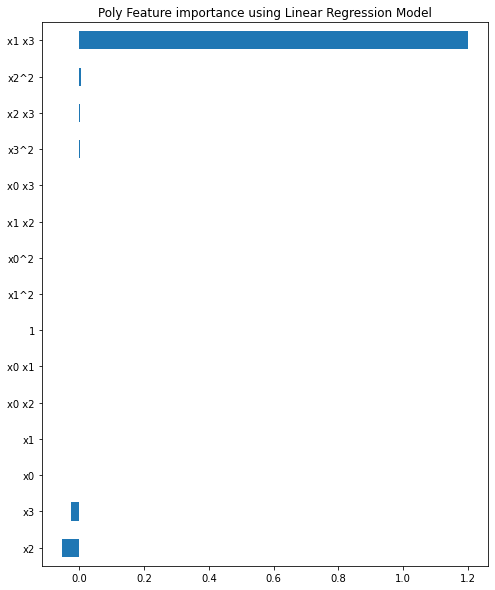

In [40]:
coef_p = pd.Series(reg8.coef_, index = poly.get_feature_names())
imp_coef = coef_p.sort_values()

plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Poly Feature importance using Linear Regression Model")

Вспомним, о каких колонках идет речь:

In [44]:
d.columns

Index(['total_floors', 'total_apartments', 'number_of_entrances',
       'mean_per_family', 'all_people'],
      dtype='object')

Получается, бОльший вес имеет признак х1 * х3. Напомню, это total_apartments * mean_per_family. А ведь именно он и является основой формирования целевого признака. Далее точно так же следует признак с количеством подъездов, потом среднее число людей в одной квартире. Завершает число наиболее значимых признаков количество подъездов, возведенное в квадрат; количество подъездов, умноженное на среднее число людей в квартире и, наконец, число людей в квартире в квадрате. Остальные признаки "не выстрелили".

### Вывод

Таким образом, цель работы - достичь базовое понимание проблемы качества данных - достигнута. В ходе работы были сделаны несколько шагов.
**Первый шаг** - создание датасета при помощи средств библиотеки numpy и рандомных значений.  
**Второй шаг** - предобработка данных и EDA.  
**Третий шаг** - обучение линейной регрессии. В ходе обучения и последующей минимизации Mean absolute error были созданы новые признаки. Также было оценено влияние признаков на обучение модели. После исключения из выборки не имеющих важности признаков модель показала наилучший результат.  
**Четвертый шаг** - создание признаков при помощи PolynomialFeatures. Обученная модель показала второй по общей значимости результат. Тем не менее, данный метод себя хорошо зарекомендовал, т.к. в данном случае, для данной задачи он гораздо быстрее помог найти минимум, избегая при этом перебора фичей и создания новых фичей с последующим обучением моделей. Что помогло сэкономить время, а результат оказался одним из лучших.